**CHAP 6 : Data Preparation for machine learning and AI**

Note: Original dataset can be found here: https://www.kaggle.com/competitions/bike-sharing-demand/data

# Notebook initialization

In [1]:
!wget https://raw.githubusercontent.com/datacorner/dataprep-handbook/main/bikerental/rental_train.csv
!wget https://raw.githubusercontent.com/datacorner/dataprep-handbook/main/bikerental/rental_test.csv

--2024-11-23 08:39:57--  https://raw.githubusercontent.com/datacorner/dataprep-handbook/main/bikerental/rental_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 563066 (550K) [text/plain]
Saving to: ‘rental_train.csv.1’

rental_train.csv.1  100%[===================>] 549.87K  --.-KB/s    in 0.05s   

2024-11-23 08:39:57 (10.2 MB/s) - ‘rental_train.csv.1’ saved [563066/563066]

--2024-11-23 08:39:57--  https://raw.githubusercontent.com/datacorner/dataprep-handbook/main/bikerental/rental_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.preprocessing import OneHotEncoder

In [3]:
df_train = pd.read_csv("/content/rental_train.csv")
df_test = pd.read_csv("/content/rental_test.csv")

In [4]:
df_train.columns

Index(['datetime', 'season', 'workingday', 'weather', 'temp',
       'feels like temp', 'humidity', 'windspeed', 'Nb of rental'],
      dtype='object')

In [5]:
df_train.head()

,datetime,season,workingday,weather,temp,feels like temp,humidity,windspeed,Nb of rental
0,2011-01-01 00:00:00,spring,no,Clear,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,spring,no,Clear,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,spring,no,Clear,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,spring,no,Clear,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,spring,no,Clear,9.84,14.395,75,0.0,1


In [6]:
df_test.head()

,datetime,season,workingday,weather,temp,feels like temp,humidity,windspeed,Nb of rental
0,2012-08-16 23:00:00,fall,yes,Clear,28.70,32.575,54,7.0015,226
1,2012-08-17 00:00:00,fall,yes,Clear,27.88,12.120,57,11.0014,88
2,2012-08-17 01:00:00,fall,yes,Clear,27.06,12.120,65,7.0015,54
3,2012-08-17 02:00:00,fall,yes,Clear,27.06,12.120,61,8.9981,19
4,2012-08-17 03:00:00,fall,yes,Clear,26.24,12.120,65,7.0015,6


# Preparing Work

## Check missing data

In [7]:
def display_missing_values(df):
  # Calculate the percentage of missing values in each column
  missing_percentage = df.isnull().sum() / len(df) * 100
  print("% of Missing values per column:")
  print(missing_percentage.apply(lambda x: f"{x:.1f} %"))
  print("Rows: {} | Columns: {}".format(df.shape[0], df.shape[1]))
display_missing_values(df_train)

% of Missing values per column:
datetime           0.0 %
season             0.0 %
workingday         0.0 %
weather            0.0 %
temp               0.0 %
feels like temp    0.0 %
humidity           0.0 %
windspeed          0.0 %
Nb of rental       0.0 %
dtype: object
Rows: 8990 | Columns: 9


## Detecting the non numerical columns

In [8]:
# List the non-numerical columns
cols_non_numeric = df_train.select_dtypes(exclude=['number']).columns
print("Not numeric columns :", cols_non_numeric)

Not numeric columns : Index(['datetime', 'season', 'workingday', 'weather'], dtype='object')


## Detecting the categorical columns

Note: If the columns (dataframe pandas) is already mentionned as categorical, we can use select_dtypes in the same way:

In [9]:
cols_categ = df_train.select_dtypes(include=['category']).columns
cols_categ

Index([], dtype='object')

If columns are not encoded in category, but are objects (object), a common method is to identify columns with a limited number of unique values, which is often the case for categorical columns.

In [10]:
thres = 10  # Par exemple, les colonnes avec moins de 10 valeurs uniques sont considérées comme catégorielles
cols_categ = [col for col in df_train.columns if df_train[col].nunique() < thres and df_train[col].dtype == 'object']
cols_non_categ = [col for col in df_train.columns if df_train[col].nunique() >= thres and df_train[col].dtype == 'object' or df_train[col].dtype != 'object']
print("Categorical columns :", cols_categ)
print("Non Categorical columns (Objects only):", cols_non_categ)

Categorical columns : ['season', 'workingday', 'weather']
Non Categorical columns (Objects only): ['datetime', 'temp', 'feels like temp', 'humidity', 'windspeed', 'Nb of rental']


Optional: convert the real categorical columns in a categorical type:

In [11]:
for col in df_train.columns:
    if df_train[col].nunique() < thres:
        df_train[col] = df_train[col].astype('category')
cols_categ = df_train.select_dtypes(include=['category']).columns
cols_categ

Index(['season', 'workingday', 'weather'], dtype='object')

## Split the dataset by features type (categorical or not)

In [12]:
df_train_categ = df_train[ cols_categ ]
df_train_non_categ = df_train[ cols_non_categ ]

## Managing the datetime feature

In [13]:
def manage_datetime(df):
  # Convert the column to a datetime object (if not already in datetime format)
  df['datetime'] = pd.to_datetime(df['datetime'])
  # Extract the hour from the datetime column
  df['hour'] = df['datetime'].dt.hour
  df = df.drop(columns=['datetime'])
  return df

df_train_non_categ = manage_datetime(df_train_non_categ)
df_train_non_categ.head()

<ipython-input-13-7de8f6bebe92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['datetime'])
<ipython-input-13-7de8f6bebe92>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['datetime'].dt.hour


,temp,feels like temp,humidity,windspeed,Nb of rental,hour
0,9.84,14.395,81,0.0,16,0
1,9.02,13.635,80,0.0,40,1
2,9.02,13.635,80,0.0,32,2
3,9.84,14.395,75,0.0,13,3
4,9.84,14.395,75,0.0,1,4


## Look at the weather values in both training and test datasets

In [14]:
df_train["weather"].value_counts()

,count
weather,
Clear,6054
Mist,2210
Light Rain/snow,725
Heavy Rain,1


In [15]:
df_test["weather"].value_counts()

,count
weather,
Clear,1132
Mist,599
Light Rain/snow,134
Cloudy,31


Note that the test set has a new value (Cloudy) !

# One-hot encoding (for training)

In [16]:
cols_categ = ['season', 'workingday', 'weather']
encoder = OneHotEncoder(sparse_output=False)
# Fit and transform the data
onehot_encoded = encoder.fit_transform(df_train_categ[cols_categ])
# Get feature names (optional)
feature_names = encoder.get_feature_names_out(cols_categ)
# Convert the result to a DataFrame for better readability
df_onehot_encoded = pd.DataFrame(onehot_encoded, columns=feature_names)
# Concatenate the encoded DataFrame with the remaining non-categorical columns:
df_final = pd.concat([df_train_non_categ, df_onehot_encoded], axis=1)

In [17]:
df_final.head()

,temp,feels like temp,humidity,windspeed,Nb of rental,hour,season_fall,season_spring,season_summer,season_winter,workingday_no,workingday_yes,weather_Clear,weather_Heavy Rain,weather_Light Rain/snow,weather_Mist
0,9.84,14.395,81,0.0,16,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,9.02,13.635,80,0.0,40,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,9.02,13.635,80,0.0,32,2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,9.84,14.395,75,0.0,13,3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,9.84,14.395,75,0.0,1,4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


# One-hot encoding (managing 2 sets)

In [18]:
# Preprocess test data: Replace infrequent or unseen categories with "Unknown"
for col in cols_categ:
    df_test[col] = df_test[col].fillna("Unknown")
    df_test[col] = df_test[col].where(df_test[col].isin(df_train[col].unique()), "Unknown")

# Convert any unseen values during encoding to "Unknown"
encoder = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist')
# Fit and transform the data for training & test
onehot_encoded_train = encoder.fit_transform(df_train[cols_categ])
onehot_encoded_test = encoder.transform(df_test[cols_categ])
# Get feature names, including "Unknown" (optional)
feature_names = encoder.get_feature_names_out(cols_categ)
# Convert the result to a DataFrame for better readability
df_onehot_encoded_train = pd.DataFrame(onehot_encoded_train, columns=feature_names)
df_onehot_encoded_test = pd.DataFrame(onehot_encoded_test, columns=feature_names)

In [19]:
df_onehot_encoded_train.columns

Index(['season_fall', 'season_spring', 'season_summer', 'season_winter',
       'workingday_no', 'workingday_yes', 'weather_Clear',
       'weather_Heavy Rain', 'weather_Light Rain/snow', 'weather_Mist'],
      dtype='object')

In [20]:
df_onehot_encoded_test.columns

Index(['season_fall', 'season_spring', 'season_summer', 'season_winter',
       'workingday_no', 'workingday_yes', 'weather_Clear',
       'weather_Heavy Rain', 'weather_Light Rain/snow', 'weather_Mist'],
      dtype='object')

In [21]:
df_onehot_encoded_train.head()

,season_fall,season_spring,season_summer,season_winter,workingday_no,workingday_yes,weather_Clear,weather_Heavy Rain,weather_Light Rain/snow,weather_Mist
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [22]:
df_onehot_encoded_test.head()

,season_fall,season_spring,season_summer,season_winter,workingday_no,workingday_yes,weather_Clear,weather_Heavy Rain,weather_Light Rain/snow,weather_Mist
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [23]:
df_onehot_encoded.columns

Index(['season_fall', 'season_spring', 'season_summer', 'season_winter',
       'workingday_no', 'workingday_yes', 'weather_Clear',
       'weather_Heavy Rain', 'weather_Light Rain/snow', 'weather_Mist'],
      dtype='object')

# Feature scaling

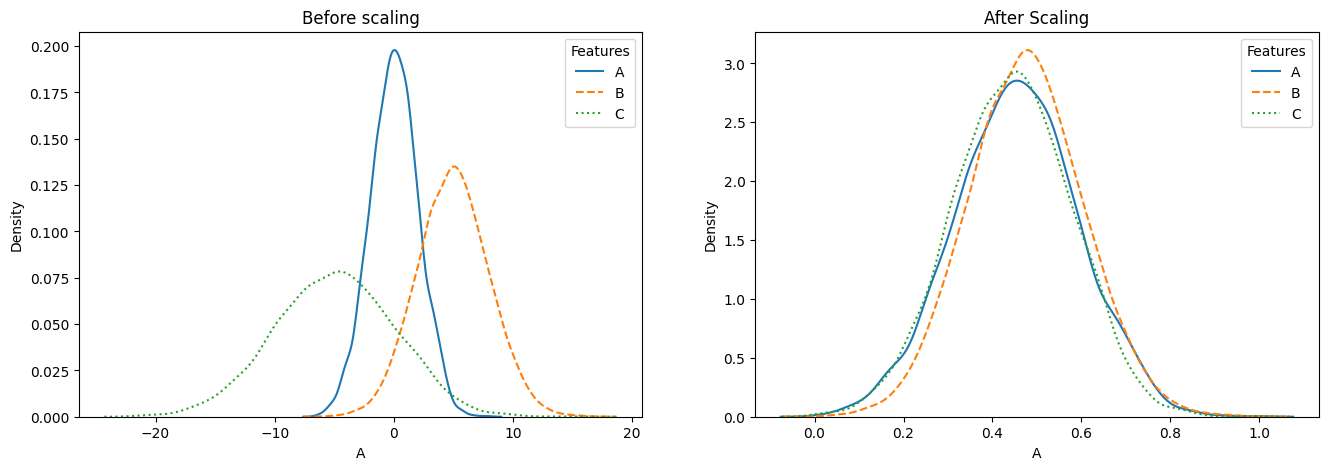

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

np.random.seed(1)
NBROWS = 5000

def plotGraph(pdf, pscaled_df):
    fig, (a, b) = plt.subplots(ncols=2, figsize=(16, 5))
    a.set_title("Before scaling")
    b.set_title("After Scaling")
    line_styles = ['-', '--', ':']  # Different line styles for the curves

    for i, col in enumerate(pdf.columns):
        sns.kdeplot(pdf[col], ax=a, linestyle=line_styles[i % len(line_styles)])
        sns.kdeplot(pscaled_df[col], ax=b, linestyle=line_styles[i % len(line_styles)])

    a.legend(pdf.columns, title="Features", loc="upper right")
    b.legend(pdf.columns, title="Features", loc="upper right")
    plt.show()

df = pd.DataFrame({
    'A': np.random.normal(0, 2, NBROWS),
    'B': np.random.normal(5, 3, NBROWS),
    'C': np.random.normal(-5, 5, NBROWS)
})

scaler = MinMaxScaler()
keepCols = ['A', 'B', 'C']
scaled_df = scaler.fit_transform(df[keepCols])
scaled_df = pd.DataFrame(scaled_df, columns=keepCols)

plotGraph(df[keepCols], scaled_df)

In [25]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(df_final)

# Convert the scaled array back to a DataFrame with the same column names
df_scaled = pd.DataFrame(scaled_array, columns=df_final.columns, index=df_final.index)

# Display the scaled DataFrame
df_scaled.head()

,temp,feels like temp,humidity,windspeed,Nb of rental,hour,season_fall,season_spring,season_summer,season_winter,workingday_no,workingday_yes,weather_Clear,weather_Heavy Rain,weather_Light Rain/snow,weather_Mist
0,0.224490,0.305068,0.81,0.0,0.016741,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.204082,0.288064,0.80,0.0,0.043527,0.043478,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.204082,0.288064,0.80,0.0,0.034598,0.086957,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.224490,0.305068,0.75,0.0,0.013393,0.130435,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.224490,0.305068,0.75,0.0,0.000000,0.173913,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [26]:
df_scaled.columns.shape

(16,)

# Discretization or Binning

In [41]:
df_train["temp"].min()

0.82

In [27]:
# Define the bin edges and labels
bins = [0, 15, 30, 50]  # Example bin edges for 'Cold', 'Moderate', 'Hot'
labels = ['Cold', 'Moderate', 'Hot']

# Apply discretization to the 'temp' column
df_train['temp_binned'] = pd.cut(df_train['temp'], bins=bins, labels=labels, right=True)

# Show the resulting dataframe
df_train.head()

,datetime,season,workingday,weather,temp,feels like temp,humidity,windspeed,Nb of rental,temp_binned
0,2011-01-01 00:00:00,spring,no,Clear,9.84,14.395,81,0.0,16,Cold
1,2011-01-01 01:00:00,spring,no,Clear,9.02,13.635,80,0.0,40,Cold
2,2011-01-01 02:00:00,spring,no,Clear,9.02,13.635,80,0.0,32,Cold
3,2011-01-01 03:00:00,spring,no,Clear,9.84,14.395,75,0.0,13,Cold
4,2011-01-01 04:00:00,spring,no,Clear,9.84,14.395,75,0.0,1,Cold


# Dimensionality reduction

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_scaled.drop(['Nb of rental'], axis=1)  # Drop target variable
y = df_train['Nb of rental']

pca = PCA(n_components=6)  # Reduce to 15 features
X_pca = pca.fit_transform(X)

# Explained variance ratio
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))  # Check how much variance is retained

[0.23138184 0.20226053 0.17825689 0.14792078 0.09430994 0.05886731]
0.9129972854431336


In [30]:
X_pca = pd.DataFrame(X_pca)

# Resampling technique

In [31]:
def categorize_rentals(df):
    # Define thresholds for categorizing rentals (these can be adjusted based on the dataset)
    high_threshold = 500  # Define a value for high rentals
    low_threshold = 100  # Define a value for low rentals

    # Create a new column 'rental_category' based on conditions
    # 'Low Rental' -> 0 / 'Medium Rental' -> 1, 'High Rental' -> 2
    df['rental_category'] = pd.cut(df['Nb of rental'],
                                   bins=[-float('inf'), low_threshold, high_threshold, float('inf')],
                                   labels=[0, 1, 2])

    return df

df = categorize_rentals(df_train)
df.head()

,datetime,season,workingday,weather,temp,feels like temp,humidity,windspeed,Nb of rental,temp_binned,rental_category
0,2011-01-01 00:00:00,spring,no,Clear,9.84,14.395,81,0.0,16,Cold,0
1,2011-01-01 01:00:00,spring,no,Clear,9.02,13.635,80,0.0,40,Cold,0
2,2011-01-01 02:00:00,spring,no,Clear,9.02,13.635,80,0.0,32,Cold,0
3,2011-01-01 03:00:00,spring,no,Clear,9.84,14.395,75,0.0,13,Cold,0
4,2011-01-01 04:00:00,spring,no,Clear,9.84,14.395,75,0.0,1,Cold,0


In [32]:
df["rental_category"].value_counts()

,count
rental_category,
1,4683
0,3777
2,530


In [33]:
y = df["rental_category"]

In [34]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)
print("Augmentation by {} ".format((1 - X_pca.shape[0] / X_resampled.shape[0]) * 100))

Augmentation by 36.00968040429924 


In [35]:
y_resampled.value_counts()

,count
rental_category,
0,4683
1,4683
2,4683


In [36]:
X_resampled.shape

(14049, 6)

In [37]:
X_pca.shape

(8990, 6)

In [38]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced')
model.fit(X_pca, y)

RandomForestClassifier(class_weight='balanced')